# Predicting late payment based on first installment characteristics

In [163]:
# import relevant modules
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import math
import datetime as dt
from scipy import stats


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV


In [112]:
# Import query results to label whether each loan was repaid

# These loans were repaid in fewer than 6 months
repaid_6mo = pd.read_csv('~/Queries_20160929/Loans_Paid_LessThan6mo.csv')

# These loans were on time at 6 months
ontime_6mo = pd.read_csv('~/Queries_20160929/Loans_ontime_6mo.csv')

# These loans had either never been paid or were late at 6 months
late_6mo = pd.read_csv('~/Queries_20160929/Loans_Late_6mo.csv')

In [113]:
# set late label for loans based on how they were paid at 6 months
repaid_6mo['late'] = 0
ontime_6mo['late'] = 0
late_6mo['late'] = 1

In [114]:
# Make a single dataframe with all loans, including loan_id, borrower_id, and whether they were late.

labeledLoans = repaid_6mo[['loan_id', 'borrower_id', 'late']]
labeledLoans = labeledLoans.append(ontime_6mo[['loan_id', 'borrower_id', 'late']])
labeledLoans = labeledLoans.append(late_6mo[['loan_id', 'borrower_id', 'late']])

print len(labeledLoans)
labeledLoans.head()

22381


,loan_id,borrower_id,late
0,4627,10644,0
1,4628,10463,0
2,4737,14745,0
3,4741,12061,0
4,4755,4190,0


In [115]:
# Import data related to all the loans

loanInfo = pd.read_csv('~/Queries_20160929/AllLoans_firstPayment1.csv')
print len(loanInfo)
loanInfo.head()

20831


,loan_id,borrower_id,disbursed_at,due_date,time_diff,due_amount,paid_amount,loan_amt,lender_interest_rate,applied_at,time_diff_app_disb,currency_code
0,4737,14745,2014-01-21 23:00:00,2014-01-31 23:00:00,-21,13,13,50,2.63,2013-12-20 03:27:37,32,KES
1,4751,4034,2014-01-22 23:00:00,2014-01-30 23:00:00,8,6,6,281,3.71,2013-12-21 09:14:50,32,KES
2,4752,7697,2014-01-29 15:13:48,2014-02-06 15:13:48,NaN,16,NaN,96,0.00,2013-12-21 13:20:25,39,KES
3,4762,8171,2014-01-01 23:00:00,2014-01-12 23:00:00,0,3,3,50,2.75,2013-12-23 12:23:26,9,KES
4,4769,11482,2014-01-01 23:00:00,2014-01-12 23:00:00,0,26,26,448,6.74,2013-12-26 05:59:11,6,KES


In [116]:
# change disbursed_at, due_date, and applied_at to Python datetime objects

def convert_to_dt(string):
    try:
        dateobj = dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
        return dateobj.date()
    except:
        pass

loanInfo.disbursed_at = loanInfo.disbursed_at.apply(convert_to_dt)
loanInfo.applied_at = loanInfo.applied_at.apply(convert_to_dt)
loanInfo.due_date = loanInfo.due_date.apply(convert_to_dt)

In [117]:
# It is clear above that some people never paid the loan at all. This occurs when time_diff = NaN. 
# Since these borrowers never paid, their value for time_diff is set to a large number, in this case 200 days.

loanInfo.time_diff = loanInfo.time_diff.fillna(200)

In [118]:
# Want to correlate borrowers in loans in two dictionaries
# The dictionary loans has each loan number as a key and borrower as a value
# the dictionary borrowers has each borrower as a key and their loans as a list of values

borrowers_loans = labeledLoans[['loan_id', 'borrower_id']]

loans = {}
borrowers = {}
for index, loan_id, borrower_id in borrowers_loans.itertuples():
    if loan_id not in loans:
        loans[loan_id] = borrower_id
    if borrower_id not in borrowers:
        borrowers[borrower_id] = [loan_id]
    else:
        borrowers[borrower_id].append(loan_id)

In [125]:
# Split the LoanInfo dataframe into several smaller dataframes for first loans, second loans, etc.
# Borrowers with only one loan are single-loan borrowers, or slb 
# Borrowers with more than one loan are multi-loan borrowers, or mlb
# the loans for multi-loan borrowers are split into their first loan (fl), second loan (sl), and third loan (tl)

# This is the single piece of code that takes the longest to run.

slb = pd.DataFrame()
mlb_fl = pd.DataFrame()
mlb_sl = pd.DataFrame()
mlb_tl = pd.DataFrame()

for keys, vals in borrowers.iteritems():
    if len(vals) == 1:
        slb = slb.append(loanInfo[loanInfo.loan_id == vals])
    elif len(vals) > 1:
        fl = vals[0] # the first item for a given borrower id = the first loan
        sl = vals[1] # the second item is the second loans
        mlb_fl = mlb_fl.append(loanInfo[loanInfo.loan_id == fl])
        mlb_sl = mlb_sl.append(loanInfo[loanInfo.loan_id == sl])
        try:
            tl = vals[2] # the third item is the third loan_id
            mlb_tl = mlb_tl.append(loanInfo[loanInfo.loan_id == tl])
        except:
            continue

In [58]:
# Merge the labels with the loan information, and first examine some overall statistics

labeledLoanInfo = pd.merge(loanInfo, labeledLoans, how = 'inner', on = 'loan_id')

In [83]:
labeledLoanInfo[['loan_id', 'time_diff', 'late']].head()

,loan_id,time_diff,late
0,4737,-21,0
1,4751,8,0
2,4762,0,0
3,4769,0,0
4,4777,-1,0


### Overall distribution of initial payment times

[(-100, 250)]

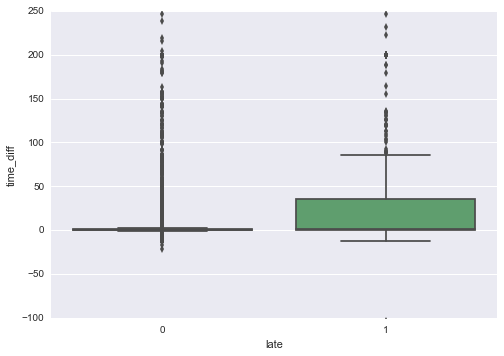

In [84]:
# First plot: what is the overall distribution of time differences between the due date and the paid date
# for the first installment?

ax = sns.boxplot(x="late", y="time_diff", data=labeledLoanInfo)
ax.set(ylim=(-100, 250))

[(-100, 250)]

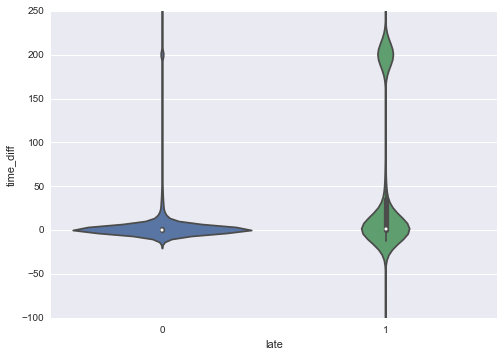

In [85]:
ax = sns.violinplot(x="late", y="time_diff", data=labeledLoanInfo, cut = 0)
ax.set(ylim=(-100, 250))

### Timeliness by Loan Number

In [61]:
# Now want to get default probability if payment status checked at various dates after the first date.

checkDates = [0, 5, 10, 15, 20, 30, 50]

def getLateRate(checkDates, df):
    """ Returns dictionary (to turn into a dataframe) with late probabilities for outstanding loans various days
    past due. Dataframe (df) must have column 'late' and 'time_diff'. """
    late_frac = []
    late_frac_CI = []
    for date in checkDates:
        laterate = float(sum(df[df.late == 1].time_diff >= date)) / sum(df.time_diff >=date)
        CI = math.sqrt((laterate*(1-laterate))/sum(df.time_diff >=date))
        late_frac.append(laterate)
        late_frac_CI.append(CI)
    
    lateProb = {
        'daysAfterDue': checkDates,
        'fraction_late': late_frac,
        'CI': late_frac_CI
    }
    
    return lateProb


def RiskRatio(checkDates, df):
    """ Has same df requirements as getLateRate. Returns list of risk ratios"""
    
    rr = []
    for date in checkDates:
        numerator = float(sum(df[df.late == 1].time_diff >= date)) / sum(df.time_diff >=date)
        denominator = float(sum(df[df.late == 1].time_diff <= date)) / sum(df.time_diff <=date)
        rr.append(numerator/denominator)
    return rr


In [62]:
allLoans_lateProbs = getLateRate(checkDates, labeledLoanInfo)
allLoans_rr = RiskRatio(checkDates, labeledLoanInfo)

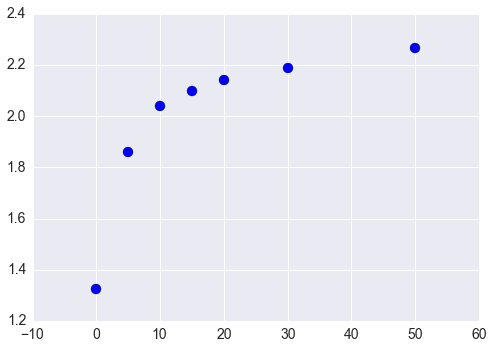

In [63]:
# Plot risk ratio as a function of number of days after the initial installment due date
# For example, if a loan is still outstanding 10 days after it was due, it is twice as likely to default
# as a loan that had been paid by that time.

fig, ax = plt.subplots()
plt.scatter(checkDates, allLoans_rr, s = 100)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.show()

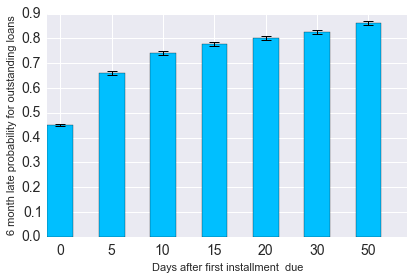

In [88]:
# Plot the default probability for loans that are outstanding some number of days after the first installment
# due date. For example, loans still outstanding at 10 days after the initial due date have a 75% chance
# of defaulting (being late at 6 months)

allLoans_lateProbs_df = pd.DataFrame(allLoans_lateProbs)

indicies = np.arange(len(allLoans_lateProbs_df))
width = 0.5

fig, ax = plt.subplots(figsize = (6.44,4))
rects = ax.bar(indicies, allLoans_lateProbs_df.fraction_late, width, color = 'deepskyblue', yerr= allLoans_lateProbs_df.CI, 
              error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))
ax.set_ylabel('6 month late probability for outstanding loans')
ax.set_xlabel('Days after first installment  due')
#ax.set_title('6 Month Late Payment Risk')
ax.set_xticks(indicies + width/2)
ax.set_xticklabels(allLoans_lateProbs_df.daysAfterDue)


for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)


plt.show()

In [124]:
# This data frame shows information about the first loan for borrowers who had more than one loan
mlb_fl.head()

,loan_id,borrower_id_x,disbursed_at,due_date,time_diff,due_amount,paid_amount,loan_amt,lender_interest_rate,applied_at,time_diff_app_disb,currency_code,borrower_id_y,late
5836,16330,32768,2015-04-22,2015-05-03,0,7.00,7.00,78,0,2015-04-11,11,KES,32768,0
5197,15006,32774,2015-03-20,2015-03-29,0,17.00,17.00,100,0,2015-03-08,12,GHS,32774,0
5599,15842,32775,2015-04-08,2015-04-19,9,18.00,18.00,100,0,2015-03-27,12,KES,32775,0
11756,28020,32777,2016-02-07,2016-02-18,2,2.01,2.01,91,0,2016-02-06,1,KES,32777,0
5154,14876,32779,2015-03-28,2015-04-05,0,7.00,7.00,100,0,2015-03-05,22,IDR,32779,0


In [134]:
# Now I will look at each of the populations of loans individually, which starts by labeling them.

slb_labeled = pd.merge(slb, labeledLoans, how = 'inner', on = 'loan_id')

mlb_fl_labeled = pd.merge(mlb_fl, labeledLoans, how = 'inner', on = 'loan_id')
mlb_sl_labeled = pd.merge(mlb_sl, labeledLoans, how = 'inner', on = 'loan_id')
mlb_tl_labeled = pd.merge(mlb_tl, labeledLoans, how = 'inner', on = 'loan_id')

In [127]:
# The data for all first loans contains the first loans that never received a second loan (slb)
# as well as the first loan for people who have receied second loans (mlb_fl)
firstloans = slb_labeled.append(mlb_fl_labeled)

In [71]:
# These are the late probabilities and risk ratios for the loans broken down by loan number

lateProbs_firstLoan = getLateRate(checkDates, firstloans)
firstLoan_rr = RiskRatio(checkDates, firstloans)

lateProbs_secondLoan = getLateRate(checkDates, mlb_sl_labeled)
secondLoan_rr = RiskRatio(checkDates, mlb_sl_labeled)

lateProbs_thirdLoan = getLateRate(checkDates, mlb_tl_labeled)
thirdLoan_rr = RiskRatio(checkDates, mlb_tl_labeled)

In [72]:
# Put the results of the lateProbs calculations into data frames
loan1 = pd.DataFrame(lateProbs_firstLoan)
loan2 = pd.DataFrame(lateProbs_secondLoan)
loan3 = pd.DataFrame(lateProbs_thirdLoan)

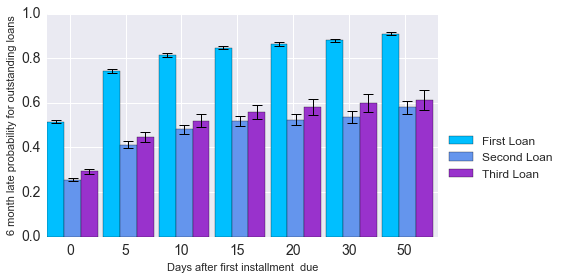

In [89]:
# Making a bar plot

indicies = np.arange(len(loan1))
width = 0.3

fig, ax = plt.subplots(figsize = (7,4))

rects1 = ax.bar(indicies, loan1.fraction_late, width, color = 'deepskyblue', 
               yerr= loan1.CI,
              error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))
rects2 = ax.bar(indicies + width, loan2.fraction_late, width, color='cornflowerblue', yerr=loan2.CI,
               error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))
rects3 = ax.bar(indicies + 2*width, loan3.fraction_late, width, color='darkorchid', yerr=loan3.CI,
               error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))

ax.set_ylabel('6 month late probability for outstanding loans')
ax.set_xlabel('Days after first installment  due')
#ax.set_ylabel('Late Rate For Outstanding Loans')
#ax.set_xlabel('Days after Week1 Loan Due')
#ax.set_title('6 Month Late Payment Risk')
ax.set_xticks(indicies + (float(4)/3)*width)
ax.set_xticklabels((checkDates))
ax.legend((rects1[0], rects2[0], rects3[0]), ('First Loan', 'Second Loan', 'Third Loan'), loc = 'best', bbox_to_anchor=(1, 0.5),
         prop={'size':12})
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

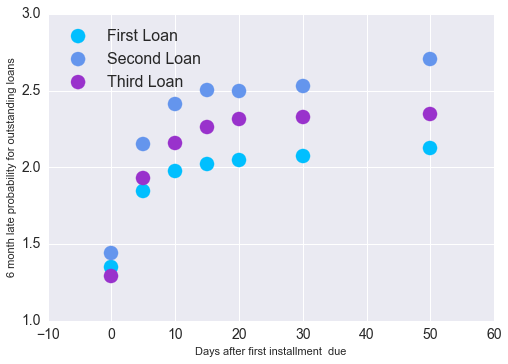

In [90]:
# Split out and plot the risk ratios for different plots

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(checkDates, firstLoan_rr, s = 200, color = 'deepskyblue', label = 'First Loan')
ax.scatter(checkDates, secondLoan_rr, s = 200, color = 'cornflowerblue', label = 'Second Loan')
ax.scatter(checkDates, thirdLoan_rr, s = 200, color = 'darkorchid', label = 'Third Loan')
ax.legend(loc = 'upper left', prop={'size':16})
ax.set_ylabel('6 month late probability for outstanding loans')
ax.set_xlabel('Days after first installment  due')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.show()

### Timeliness by Country

In [91]:
# Now lets separate by country (indicated by "country code")

def getLateRate_country(checkDates, df, country):
    """ Return dictionary to turn into a dataframe with late probabilities for outstanding loans various days
    past due. Dataframe (df) must have column 'late' and 'time_diff'. """
    late_frac = []
    late_frac_CI = []
    df = df[df['currency_code'] == country]
    for date in checkDates:
        try:
            laterate = float(sum(df[df.late == 1].time_diff >= date)) / sum(df.time_diff >=date)
            CI = math.sqrt((laterate*(1-laterate))/sum(df.time_diff >=date))
            late_frac.append(laterate)
            late_frac_CI.append(CI)
        except ZeroDivisionError:
            continue
    
    lateProb = {
        'daysAfterDue': checkDates,
        'fraction_late': late_frac,
        'CI': late_frac_CI
    }
    
    return lateProb


def RiskRatio_country(checkDates, df, country):
    """ Has same df requirements as getLateRate"""
    
    rr = []
    df = df[df['currency_code'] == country]
    for date in checkDates:
        numerator = float(sum(df[df.late == 1].time_diff >= date)) / sum(df.time_diff >=date)
        denominator = float(sum(df[df.late == 1].time_diff <= date)) / sum(df.time_diff <=date)
        rr.append(numerator/denominator)
    return rr

In [92]:
countries = set(labeledLoanInfo.currency_code.unique())
laterates_country = {}
riskratios_country = {}

for country in countries:
    laterates_country[country] = getLateRate_country(checkDates, labeledLoanInfo, country)

In [93]:
# Print out the list of country currency codes, as well as the number of loans that in that country

for country in countries:
    print country, len(labeledLoanInfo[labeledLoanInfo.currency_code == country])

HTG 18
IDR 1122
KES 11801
ZMW 152
GHS 4348


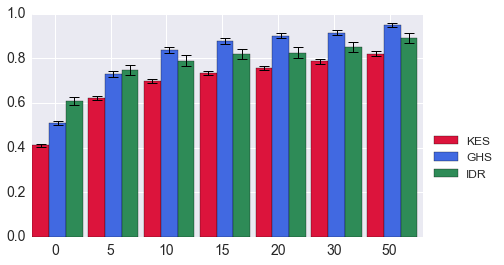

In [94]:
# Make a bar plot with bars corresponding to different countries

indicies = np.arange(len(checkDates))
width = 0.3

fig, ax = plt.subplots(figsize = (7,4))

rects1 = ax.bar(indicies, laterates_country['KES']['fraction_late'], width, color = 'crimson', 
               yerr= laterates_country['KES']['CI'], error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))
rects2 = ax.bar(indicies + width, laterates_country['GHS']['fraction_late'], width, color='royalblue',
                yerr=laterates_country['GHS']['CI'], error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))
rects3 = ax.bar(indicies + 2*width, laterates_country['IDR']['fraction_late'], width, color='seagreen', 
                yerr=laterates_country['IDR']['CI'], error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1))

#ax.set_ylabel('Late Rate For Outstanding Loans')
#ax.set_xlabel('Days after Week1 Loan Due')
#ax.set_title('6 Month Late Payment Risk')
ax.set_xticks(indicies + (float(4)/3)*width)
ax.set_xticklabels((checkDates))
ax.legend((rects1[0], rects2[0], rects3[0]), ('KES', 'GHS', 'IDR'), loc = 'best', bbox_to_anchor=(1, 0.5),
         prop={'size':12})
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

## Prediction of second loan on-time repayment based on first loan

In [135]:
# rename columns that will evetually merged
mlb_fl_labeled.rename(columns = {'borrower_id_x': 'borrower_id'}, inplace = True)
mlb_sl_labeled.rename(columns = {'borrower_id_x': 'borrower_id'}, inplace = True)
mlb_sl_labeled.head()

,loan_id,borrower_id,disbursed_at,due_date,time_diff,due_amount,paid_amount,loan_amt,lender_interest_rate,applied_at,time_diff_app_disb,currency_code,borrower_id_y,late
0,20157,32768,2015-07-22,2015-08-02,0,8,8,146,0,2015-07-07,14,KES,32768,0
1,14880,32777,2015-03-11,2015-03-22,0,2,2,100,0,2015-03-05,5,KES,32777,1
2,20236,32779,2015-07-21,2015-08-02,1,7,7,198,0,2015-07-08,12,IDR,32779,1
3,22233,32780,2015-08-28,2015-09-06,1,4,4,120,0,2015-08-20,8,KES,32780,0
4,22233,32780,2015-08-28,2015-09-06,1,4,4,120,0,2015-08-20,8,KES,32780,0


In [136]:
# Merge mlb_fl and mlb_sl dataframes on borrower_id in order to compare two loans from the same borrower
# The suffix _1 corresponds to the first loan, _2 corresponds to the second

multiloans_labeled = pd.merge(mlb_fl_labeled, mlb_sl_labeled, how = 'inner', on = 'borrower_id', suffixes=('_1', '_2'))

In [153]:
# Make some derived columns based on other columns in the data

multiloans_labeled['appTimeDiff'] = (multiloans_labeled.applied_at_2 - multiloans_labeled.applied_at_1)/pd.Timedelta(days = 1)
multiloans_labeled['InstallmentToLoanRatio1'] = multiloans_labeled.due_amount_1/multiloans_labeled.loan_amt_1
multiloans_labeled['InstallmentToLoanRatio2'] = multiloans_labeled.due_amount_2/multiloans_labeled.loan_amt_2
multiloans_labeled['PaidToDue_ratio'] = multiloans_labeled.paid_amount_1/ multiloans_labeled.paid_amount_2
multiloans_labeled['loanRatio'] = multiloans_labeled.loan_amt_2/multiloans_labeled.loan_amt_1
print multiloans_labeled.columns.values
multiloans_labeled.head()

['loan_id_1' 'borrower_id' 'disbursed_at_1' 'due_date_1' 'time_diff_1'
 'due_amount_1' 'paid_amount_1' 'loan_amt_1' 'lender_interest_rate_1'
 'applied_at_1' 'time_diff_app_disb_1' 'currency_code_1' 'borrower_id_y_1'
 'late_1' 'loan_id_2' 'disbursed_at_2' 'due_date_2' 'time_diff_2'
 'due_amount_2' 'paid_amount_2' 'loan_amt_2' 'lender_interest_rate_2'
 'applied_at_2' 'time_diff_app_disb_2' 'currency_code_2' 'borrower_id_y_2'
 'late_2' 'appTimeDiff' 'InstallmentToLoanRatio1' 'InstallmentToLoanRatio2'
 'PaidToDue_ratio' 'loanRatio']


,loan_id_1,borrower_id,disbursed_at_1,due_date_1,time_diff_1,due_amount_1,paid_amount_1,loan_amt_1,lender_interest_rate_1,applied_at_1,...,applied_at_2,time_diff_app_disb_2,currency_code_2,borrower_id_y_2,late_2,appTimeDiff,InstallmentToLoanRatio1,InstallmentToLoanRatio2,PaidToDue_ratio,loanRatio
0,16330,32768,2015-04-22,2015-05-03,0,7.00,7.00,78,0,2015-04-11,...,2015-07-07,14,KES,32768,0,87,0.089744,0.054795,0.875,1.871795
1,28020,32777,2016-02-07,2016-02-18,2,2.01,2.01,91,0,2016-02-06,...,2015-03-05,5,KES,32777,1,-338,0.022088,0.020000,1.005,1.098901
2,14876,32779,2015-03-28,2015-04-05,0,7.00,7.00,100,0,2015-03-05,...,2015-07-08,12,IDR,32779,1,125,0.070000,0.035354,1.000,1.980000
3,15267,32780,2015-03-18,2015-03-29,0,3.00,3.00,99,0,2015-03-13,...,2015-08-20,8,KES,32780,0,160,0.030303,0.033333,0.750,1.212121
4,15267,32780,2015-03-18,2015-03-29,0,3.00,3.00,99,0,2015-03-13,...,2015-08-20,8,KES,32780,0,160,0.030303,0.033333,0.750,1.212121


### Exploratory analysis

[(-5, 600)]

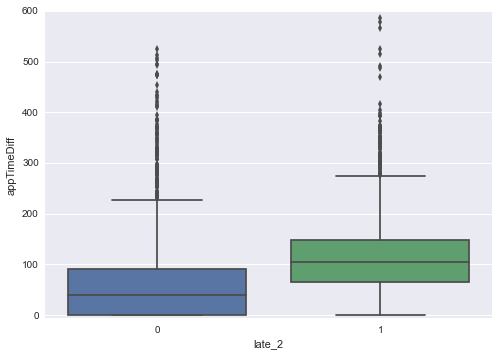

In [141]:
# Time between applied dates for first and second loans

ax = sns.boxplot(x="late_2", y="appTimeDiff", data=multiloans_labeled)
ax.set(ylim=(-5, 600))

[(0, 0.3)]

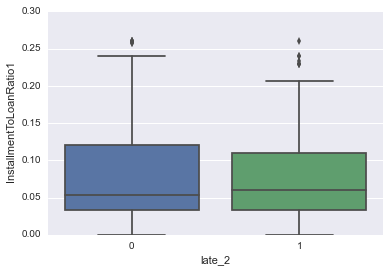

In [215]:
# Ratio of weekly installment due amount to total loan amount for first loan

ax = sns.boxplot(x="late_2", y="InstallmentToLoanRatio1", data=multiloans_labeled)
ax.set(ylim=(0, 0.3))

In [256]:
stats.ks_2samp( multiloans_labeled[multiloans_labeled.late_2 == 0].InstallmentToLoanRatio1,
                multiloans_labeled[multiloans_labeled.late_2 == 1].InstallmentToLoanRatio1)

Ks_2sampResult(statistic=0.08198263013433166, pvalue=0.0001426137945330437)

[(0, 0.3)]

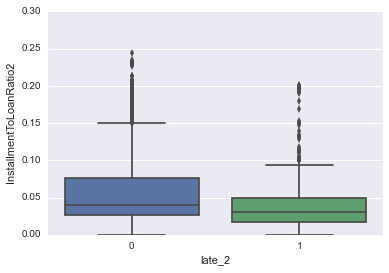

In [216]:
# Ratio of weekly installment due amount to total loan amount for second loan

ax = sns.boxplot(x="late_2", y="InstallmentToLoanRatio2", data=multiloans_labeled)
ax.set(ylim=(0, 0.3))

In [255]:
stats.ks_2samp( multiloans_labeled[multiloans_labeled.late_2 == 0].InstallmentToLoanRatio2,
                multiloans_labeled[multiloans_labeled.late_2 == 1].InstallmentToLoanRatio2)

Ks_2sampResult(statistic=0.27337646324250725, pvalue=1.5510964407206617e-46)

In [254]:
 multiloans_labeled[multiloans_labeled.late_2 == 1].InstallmentToLoanRatio2

1     0.020000
2     0.035354
6     0.064171
11    0.059140
32    0.036458
Name: InstallmentToLoanRatio2, dtype: float64

[(0, 5)]

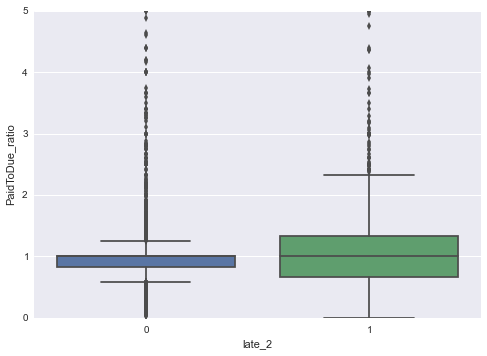

In [148]:
# Ratio of paid amount to due amount for first installment of first loan

ax = sns.boxplot(x="late_2", y="PaidToDue_ratio", data=multiloans_labeled)
ax.set(ylim=(0, 5))

[(-2, 10)]

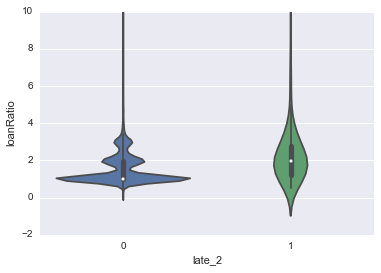

In [173]:
# Ratio of amount of first loan to amount of second loan

ax = sns.violinplot(x="late_2", y="loanRatio", data=multiloans_labeled)
ax.set(ylim=(-2, 10))

In [213]:
# Based on these distinct distributions, it seems possible to differentiate between the different populations
# and suggests that it might be possible to classify second loan timeliness based on first loan and initial second
# loan characteristics.

# Xlr = multiloans_labeled[['time_diff_1', 'due_amount_1', 'loan_amt_1', 'late_1','due_amount_2', 'loan_amt_2',
#                        'appTimeDiff', 'InstallmentToLoanRatio1']]
Xlr = X
Xlr_norm = preprocessing.normalize(X)
#labels = multiloans_labeled.late_2
labels = np.ravel(y)

# Split features and labels into train and test sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(Xlr_norm, labels, test_size=0.3, random_state=0)

In [214]:
model = LogisticRegression()
model = model.fit(X_train_lr, y_train_lr)
print model.score(X_train_lr, y_train_lr)
lrpredicted = model.predict(X_test_lr)
lrprobs = model.predict_proba(X_test_lr)
print metrics.classification_report(y_test_lr, lrpredicted)

0.825700164745
             precision    recall  f1-score   support

          0       0.82      1.00      0.90      1064
          1       0.50      0.01      0.02       238

avg / total       0.76      0.82      0.74      1302



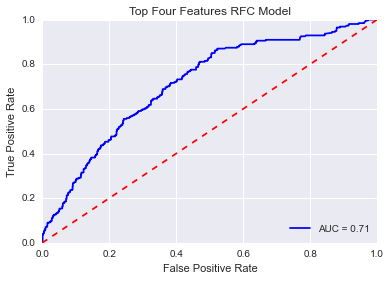

In [190]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_lr, lrprobs[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Top Four Features RFC Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [182]:
LR1 = pd.DataFrame(zip(Xlr.columns, np.transpose(model.coef_)))
LR1.columns = ['feature_name', 'weight_1']
LR1

,feature_name,weight_1
0,time_diff_1,[-0.201089987943]
1,due_amount_1,[-1.99847286352]
2,loan_amt_1,[-3.58057384139]
3,late_1,[0.125467428078]
4,due_amount_2,[-5.95478824698]
5,loan_amt_2,[1.56569377022]
6,appTimeDiff,[0.897482866873]
7,InstallmentToLoanRatio1,[-0.0693694940221]


[(-100, 100)]

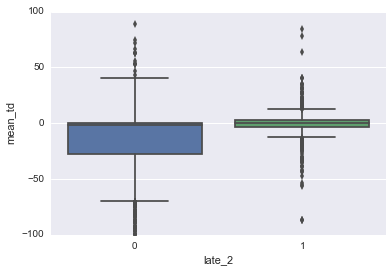

In [224]:
# mean (paid - due) time differences

ax = sns.boxplot(x="late_2", y="mean_td", data=multiloans_extra)
ax.set(ylim=(-100, 100))

[(0, 150)]

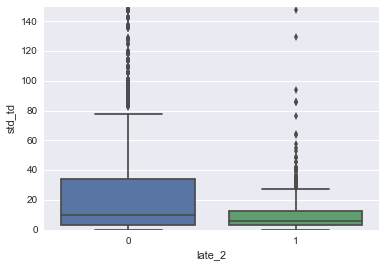

In [221]:
# Std (paid - due) time differences

ax = sns.boxplot(x="late_2", y="std_td", data=multiloans_extra)
ax.set(ylim=(0, 150))